In [88]:
%matplotlib inline

# PID-Evaluator

Forked from PID-Analyzer(python) and PIDtoolbox(Matlab).

Import libs first

In [89]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.fftpack import fft,ifft
from numpy.fft import rfft,irfft
from scipy.cluster.vq import vq,kmeans,whiten
from scipy import conj,argmax

In [90]:
# Set the log file path
logFileName = 'lsm6d_001'
logFileType = '.bbl'
logFilePath = logFileName+logFileType

# Set the blackbox_decode path
decodePath = 'blackbox_decode.exe'

# Create decode command
decodeCommand = decodePath + ' ' + logFilePath
#print(cmd)

# Decode
os.system(decodeCommand)

# blackbox_decode will create a .event file, we don't need that
junkFile = logFileName+'.01.event'
os.remove(junkFile)

dataFile = logFileName+'.01.csv'

Open files using pandas

In [91]:
df=pd.read_csv(dataFile) 
#df.head()

In [92]:
df.columns

Index(['loopIteration', ' time (us)', ' axisP[0]', ' axisP[1]', ' axisP[2]',
       ' axisI[0]', ' axisI[1]', ' axisI[2]', ' axisD[0]', ' axisD[1]',
       ' axisF[0]', ' axisF[1]', ' axisF[2]', ' rcCommand[0]', ' rcCommand[1]',
       ' rcCommand[2]', ' rcCommand[3]', ' setpoint[0]', ' setpoint[1]',
       ' setpoint[2]', ' setpoint[3]', ' vbatLatest (V)',
       ' amperageLatest (A)', ' BaroAlt (cm)', ' rssi', ' gyroADC[0]',
       ' gyroADC[1]', ' gyroADC[2]', ' accSmooth[0]', ' accSmooth[1]',
       ' accSmooth[2]', ' debug[0]', ' debug[1]', ' debug[2]', ' debug[3]',
       ' motor[0]', ' motor[1]', ' motor[2]', ' motor[3]',
       ' energyCumulative (mAh)', ' flightModeFlags (flags)',
       ' stateFlags (flags)', ' failsafePhase (flags)', ' rxSignalReceived',
       ' rxFlightChannelsValid'],
      dtype='object')

Noted that the column names in csv files are different between using blackbox_decode and using blackbox log viewer

blackbox_decode will creat an extra space in front of column names.

blackbox_decode:
- ' axisI\[0\]'

blackbox log viewer :
- 'axisI\[0\]'

In [93]:
loopIteration   = df[ 'loopIteration'].values.T
time            = df[ ' time (us)'].values.T
print(time[0])
time=time-time[0]
print(time)
diffOfTime = np.diff(time)
print(diffOfTime)
averageUs = np.median(diffOfTime)
print(averageUs)
samplingRate = 1000000/averageUs
print(samplingRate)

66436712
[        0       414       864 ... 110498720 110499113 110499464]
[414 450 337 ... 357 393 351]
382.0
2617.801047120419


In [94]:
setpointData    = df[[ ' setpoint[0]',  ' setpoint[1]', ' setpoint[2]']].values.T
gyroADCData     = df[[ ' gyroADC[0]',   ' gyroADC[1]',  ' gyroADC[2]']].values.T
gyroScaleData   = df[[ ' debug[0]',     ' debug[1]',    ' debug[2]']].values.T
thrData         = df[[ ' rcCommand[3]']].values.T[0]
print(setpointData)
print(gyroADCData)
print(gyroScaleData)
print(thrData)

[[  2   2   2 ... -45 -45 -45]
 [ -2  -2  -2 ...  -4  -4  -4]
 [  1   1   1 ...   0   0   0]]
[[  0   2  -1 ... -45 -46 -48]
 [  0   1   2 ...   3   4   4]
 [  2   1   2 ...   1   0   2]]
[[  7   5  -8 ... -44 -55 -61]
 [ -3   5   2 ...  -1   6   9]
 [  4  -6   3 ...   1   7  10]]
[1000 1000 1000 ... 1282 1282 1282]


In [95]:
def smooth(x, wnd):
    # x: NumPy 1-D array containing the data to be smoothed
    # wnd: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(x,np.ones(wnd,dtype=int),'valid')/wnd
    r = np.arange(1,wnd-1,2)
    start = np.cumsum(x[:wnd-1])[::2]/r
    stop = (np.cumsum(x[:-wnd:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

Then length of the gyro signal is 288384 

Raw step response frames: 497 

After QC process, we have 425 frames



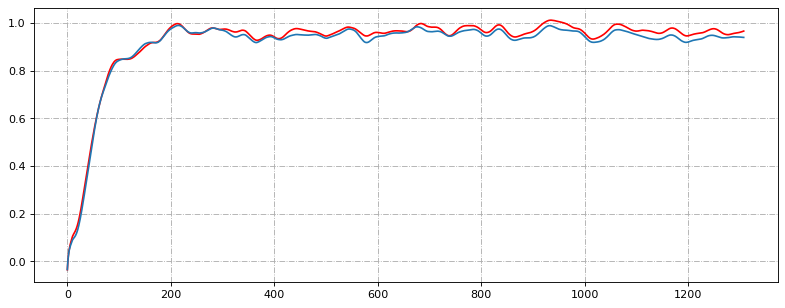

In [108]:
segment_length= int(samplingRate)*2 # 2 sec window
wnd= int(samplingRate/2)            # 500ms time window for plotting step response  
StepRespDuration_ms=500             # max dur of step resp in ms for plotting
rateHighThreshold=500               # degs/s
skipRate = 0.10

gyro_signal = gyroADCData[0]
setpoint_signal = setpointData[0]

raw_step_response = np.zeros((5000, segment_length), dtype=np.float64)
raw_input_segments = np.zeros((5000, segment_length), dtype=np.float64)
raw_frequency_response = np.zeros((5000, segment_length), dtype=np.float64)

qc_step_response = np.zeros((5000, segment_length), dtype=np.float64)
qc_input_segments = np.zeros((5000, segment_length), dtype=np.float64)
qc_frequency_response = np.zeros((5000, segment_length), dtype=np.float64)

print("Then length of the gyro signal is %d \n" %(len(gyro_signal)))

seg_vector = range(0, len(gyro_signal)-segment_length, round(segment_length*skipRate))
j = 0
jj= 0
for i in seg_vector:
    Xseg = setpoint_signal[i:i+segment_length]
    if np.max(np.abs(Xseg)) < 20:
        continue
    Yseg = gyro_signal[i:i+segment_length]
    x_fft = rfft(np.hamming(segment_length) * Xseg)
    y_fft = rfft(np.hamming(segment_length) * Yseg)
    H=x_fft/len(x_fft)
    G=y_fft/len(y_fft)
    Hcon=np.conj(H)
    imp = np.real(irfft((G * Hcon) / (H * Hcon + .0001)))# impulse response function, .0001 to avoid divide by 0
    resp = np.cumsum(smooth(imp,21))
    resp = resp - resp[1]

    raw_step_response[jj,:] = resp
    raw_input_segments[jj] = Xseg
    raw_frequency_response[jj,:]=irfft((G * Hcon) / (H * Hcon + .0001))
    jj=jj+1

    if jj>=5000:
        break

    if np.var(resp)>0.1: #use np.var to control the quality, see the kmean section below
        continue
    #plt.plot(resp)
    #break
    qc_step_response[j,:] = resp
    qc_input_segments[j] = Xseg
    qc_frequency_response[j,:] =irfft((G * Hcon) / (H * Hcon + .0001))
    #print(step_response[0])
    #break
    j=j+1


#plt.plot((np.max(qc_step_response[:j], axis=0)/j)[:wnd])
plt.figure(figsize=(12, 10), dpi= 80)
plt.subplot(2,1,1)
plt.plot((np.sum(raw_step_response[:jj], axis=0)/jj)[:wnd],c='r')
plt.plot((np.sum(qc_step_response[:j], axis=0)/j)[:wnd])
plt.grid(True,linestyle='-.')
#plt.plot((np.min(qc_step_response[:j], axis=0)/j)[:wnd])
print("Raw step response frames: %d \n" %jj)
print("After QC process, we have %d frames\n" %j)

The distortion of the signal is 24
[ 73.   2. 232.  46.   1. 143.]


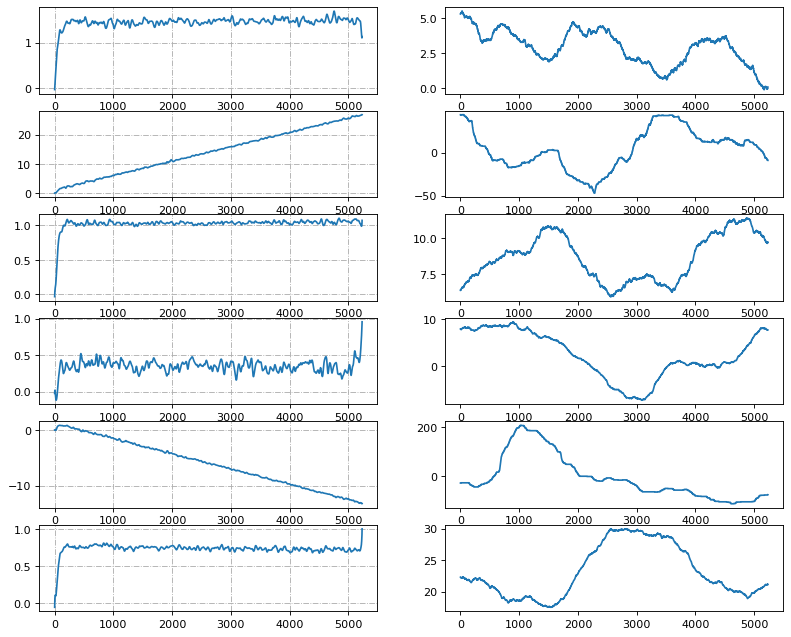

In [97]:
# Set the number of clusters
# In my test, it semems that the best value is 6
GROUP_COUNT = 6

# Foword step response to features
features = raw_step_response[0:jj,:]
#print(features)

# Whiten data
whitened = whiten(features)
#print(whitened)

# Find N clusters in the data
codebook, distortion = kmeans(whitened, GROUP_COUNT)
print("The distortion of the signal is %d" %distortion)
result = vq(whitened, codebook)
#print(result)
resp_cluster = np.zeros((GROUP_COUNT, segment_length))
setpoint_cluster = np.zeros((GROUP_COUNT, segment_length))
member_count = np.zeros(GROUP_COUNT)
for i in range(jj):
    codebook_idx = result[0][i]
    resp_cluster[codebook_idx] = resp_cluster[codebook_idx] + raw_step_response[i]
    setpoint_cluster[codebook_idx] = setpoint_cluster[codebook_idx] + raw_input_segments[i]
    member_count[result[0][i]] = member_count[result[0][i]] + 1

plt.figure(figsize=(12, 10), dpi= 80)
for i in range(GROUP_COUNT):
    plt.subplot(GROUP_COUNT,2,i*2+1)
    plt.plot(resp_cluster[i]/member_count[i])
    plt.grid(True,linestyle='-.')
    plt.subplot(GROUP_COUNT,2,i*2+2)
    plt.plot(setpoint_cluster[i]/member_count[i])
print(member_count)

The distortion of the signal is 42
[ 13.  57. 126.  48. 131.  75.]


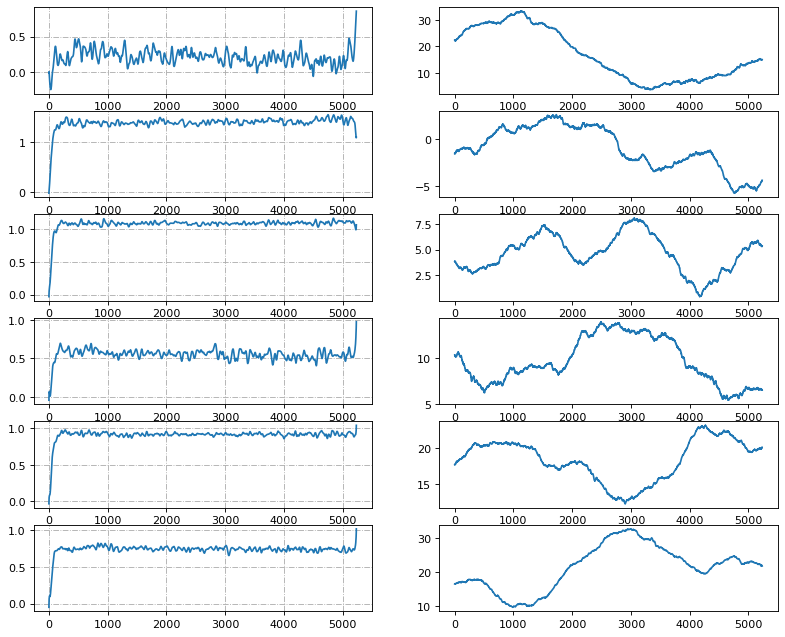

In [98]:
# Set the number of clusters
# In my test, it semems that the best value is 6
GROUP_COUNT = 6

# Foword step response to features
features = qc_step_response[0:j,:]
#print(features)

# Whiten data
whitened = whiten(features)
#print(whitened)

# Find N clusters in the data
codebook, distortion = kmeans(whitened, GROUP_COUNT)
print("The distortion of the signal is %d" %distortion)
result = vq(whitened, codebook)
#print(result)
resp_cluster = np.zeros((GROUP_COUNT, segment_length))
setpoint_cluster = np.zeros((GROUP_COUNT, segment_length))
member_count = np.zeros(GROUP_COUNT)
for i in range(j):
    codebook_idx = result[0][i]
    resp_cluster[codebook_idx] = resp_cluster[codebook_idx] + qc_step_response[i]
    setpoint_cluster[codebook_idx] = setpoint_cluster[codebook_idx] + qc_input_segments[i]
    member_count[result[0][i]] = member_count[result[0][i]] + 1

plt.figure(figsize=(12, 10), dpi= 80)
for i in range(GROUP_COUNT):
    plt.subplot(GROUP_COUNT,2,i*2+1)
    plt.plot(resp_cluster[i]/member_count[i])
    plt.grid(True,linestyle='-.')
    plt.subplot(GROUP_COUNT,2,i*2+2)
    plt.plot(setpoint_cluster[i]/member_count[i])
print(member_count)

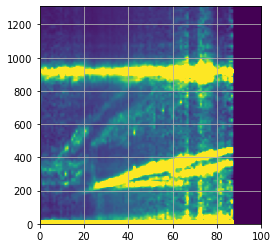

In [99]:
signal = gyroScaleData[0]
thr = thrData #1000~2000
bufferSize = 256
batch = int(len(signal)/bufferSize)
thrfft = np.zeros((100, int(bufferSize/2)), dtype=np.float64)
#timefft = np.zeros((len(signal)-bufferSize, int(bufferSize/2)), dtype=np.float64)
thrCount = np.zeros(100, dtype=np.int32)

#print(thr)
#print(batch)

for i in range(0, len(signal)-bufferSize, 10):
    idx = i
    #print(np.sum(thr[idx:idx+bufferSize])/bufferSize)
    avgThr = int(np.sum(thr[idx:idx+bufferSize])/bufferSize/10) - 100
    if avgThr < 0:
        avgThr = 0
    if avgThr > 99:
        avgThr = 99
    #print(avgThr)
    fft_data = fft(np.hanning(bufferSize) * signal[idx:idx+bufferSize], bufferSize)
    realPart = np.abs(np.real(fft_data[:int(bufferSize/2)]))/bufferSize*2
    #timefft[i]+=realPart
    thrfft[avgThr]= thrfft[avgThr]+realPart
    thrCount[avgThr] += 1
    
for i in range(100):
    if thrCount[i] != 0:
        thrfft[i]=thrfft[i]/thrCount[i]
#print(thrfft)
#plt.imshow(bitmap)
#plt.hist(bitmap, bins=256, range=(0.0, 256.0))

#plt.figure(figsize=(2, 14), dpi= 80)
plt.imshow(thrfft.T, vmax=1, aspect=0.075, interpolation='kaiser', origin='lower', extent=[0, 100, 0, samplingRate/2])
plt.grid(True,linestyle='-')

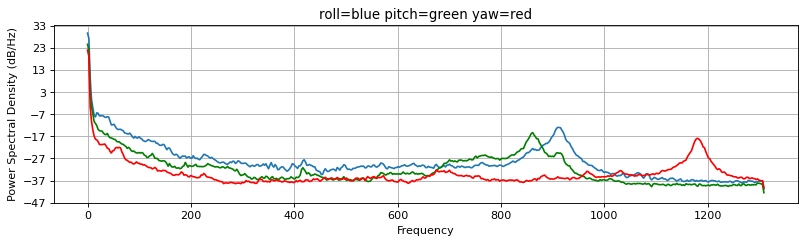

In [100]:
plt.figure(figsize=(12, 10), dpi= 80)
plt.subplot(3,1,1)
plt.title('roll=blue pitch=green yaw=red')
plt.psd(gyroADCData[0],1024,int(samplingRate))
#plt.subplot(3,1,2)
#plt.title('pitch')
plt.psd(gyroADCData[1],1024,int(samplingRate),c='g')
#plt.subplot(3,1,3)
#plt.title('yaw')
plt.psd(gyroADCData[2],1024,int(samplingRate),c='r')
plt.show()

In [101]:
#af = fft(smooth(gyro_signal,5))
#print(af)
#bf = fft(smooth(setpoint_signal,5))
#print(bf)
#c = ifft(af * conj(bf))
#print(c)

#time_shift = argmax(abs(c)) / 2
#print(time_shift)

The reason for commenting the upper cell is lack of percision

Use interp1d to increase percision

In [102]:
def inter(x):
    tmp_a = np.arange(0,len(x),1)
    tmp_b = interpolate.interp1d(tmp_a,x)
    y = tmp_b(np.arange(0,len(x)-10,0.1))
    return y
def calculateDelay(a,b):
    aFft    = fft(a)
    bFft    = fft(b)
    c       = ifft(aFft*conj(bFft))
    time_shift  = argmax(abs(c))
    return time_shift

intered_gyro = inter(gyro_signal)
intered_setpoint = inter(setpoint_signal)
setpoint_gyro = calculateDelay(intered_gyro,intered_setpoint)


In [103]:
print('The delay between input and output is %5.2fms' %(setpoint_gyro/26))

The delay between input and output is 20.12ms


In [104]:
intered_gyro_raw = inter(gyroScaleData[0])
gyro_filter_delay = calculateDelay(intered_gyro,intered_gyro_raw)

In [105]:
print('The delay caused by gyro filters is %5.2fms'%(gyro_filter_delay/26))

The delay caused by gyro filters is  2.31ms


In [106]:
print(len(gyro_signal))
print(len(intered_gyro))

288384
2883740
